# Langgraph

## imports

### 1.StateGraph:

While building an AI app, we often need to run a sequence of steps:

1. Take user input

2. Call an LLM

3. Process the response

4. Maybe loop or branch depending on the answer

Codeing this manually can get messy with lots of if/else, state tracking, and function calls.

**StateGraph** makes this cleaner by describing app as a flowchart:

> Each node = a function (like “get user input” or “call model”).

> he edges = arrows showing what happens next.

> The state = shared memory that flows through the graph.

- ***State*** → It holds your app’s memory.
- ***Nodes*** → These are functions that read the state and return updates.
- ***Reducers*** → These are rules that say how to merge new updates into the existing state.
- ***Edges*** → Connections that control the flow.
- ***END*** → Special node meaning the flow is done.

#### rules to create a graph

- Create the graph first: ```g = StateGraph(State)```

- Add a node before you reference it
    - You must add_node("name", fn) before you:
        - set it as the entry point, or
        - create an edge from/to it.

- Set the entry point to an existing node
    ```g.set_entry_point("greet")``` only after ```"greet"``` is added.

- Add edges only between existing nodes (or to ```END```)
Both endpoints must exist (except ```END```, which is special).

- Compile last
    ```app = g.compile()``` after the whole graph is wired.


# Langchain

## langchain_core: 
- its a lightweight core package of langchain
- This reperesent different kinds of chat messages in a structured way

### 1. HumanMessage:
- Represent a message sent by the user
- it has a **content** field which is the text
- it has optional metadata
- This helps track who said what in the conversation

### 2. AnyMessage:
- In LangChain we have: 
    - **HumanMessage** &rarr; user imput
    - **AIMessage** &rarr; model's response
    - **SystemMessage** &rarr; system instructions

# Typing

### Annotated:
- it take a type like str, list, Dict etc and add a metadat to it






In [1]:
from typing import Dict, TypedDict, Annotated
from langgraph.graph import StateGraph, END, add_messages, START
from langchain_core.messages import AnyMessage, HumanMessage

### Example 1

In [2]:
class AgentState(TypedDict):
    message: str

def greeting_node(state: AgentState)->AgentState:
    """Node that adds a greeting message to the state"""
    state['message']="Hey "+state['message']
    return state


In [3]:
graph=StateGraph(AgentState)
graph.add_node("greeter",greeting_node)
graph.set_entry_point("greeter")
graph.add_edge("greeter", END)
app=graph.compile()

In [4]:
print(app.invoke({"message": "there!"}))

{'message': 'Hey there!'}


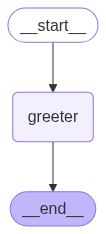

In [5]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Example 2

#### Steps:
- Define Class
- node function: read state &rarr; returns partial update
- Build the graph

In [6]:
# 1.) Define Class
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    turns: int

In [7]:
# 2.) node function 1
def greet(state: State) -> State:
    last_msg=state['messages'][-1].content
    return {
        "messages":[HumanMessage(content="Hey "+last_msg)],
        "turns": state.get("turns", 0) + 1
    }

In [8]:
def next_greet(state: State)->State:
    last_msg=state['messages'][-1].content
    return {
        "messages":[HumanMessage(content="Hello "+last_msg)],
        "turns": state["turns"]+1
    }

In [9]:
# 3) Build the graph
g=StateGraph(State)
g.add_node("greet", greet)
g.add_node("next_greet", next_greet)
g.set_entry_point("greet")
g.add_edge("greet", "next_greet")


#### &rarr; add_conditional_edges
```python
graph.add_conditional_edges(
    "decider",        # the node after which branching happens
    router_function,  # a function(state) -> key
    {
        "path1": "nodeA",
        "path2": "nodeB",
        END: END
    }
)
```
- where **"path1"** is the return value from router_function 
- if the value returned is **"path1"** than will go to **"nodeA"** else **"END"**

In [10]:
def turn_condition(state: State)->State:
    return "first" if state['turns']<2 else END

In [11]:
g.add_conditional_edges("next_greet", turn_condition,{"first": "greet", END:END})

In [12]:
app=g.compile()

In [13]:
result = app.invoke({"messages": [HumanMessage(content="")], "turns": 0})

In [14]:
result

{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='946b8307-0db0-48be-877c-68dc897cdcf7'),
  HumanMessage(content='Hey ', additional_kwargs={}, response_metadata={}, id='b361e49a-52d7-4f33-afe9-2280844028d8'),
  HumanMessage(content='Hello Hey ', additional_kwargs={}, response_metadata={}, id='5ea82a8d-4360-415c-bb73-da292960ecd5')],
 'turns': 2}

In [15]:
result2=app.invoke({
        "messages": [
            HumanMessage(content="Hey there!"),
            HumanMessage(content="How are you doing?"),
            HumanMessage(content="This is a second line in the same step."),
        ],
        "turns": 0,
    })

In [16]:
result2

{'messages': [HumanMessage(content='Hey there!', additional_kwargs={}, response_metadata={}, id='36836c0b-9fbd-48d1-be38-09a2a2f889ec'),
  HumanMessage(content='How are you doing?', additional_kwargs={}, response_metadata={}, id='7098c044-354e-447a-89ce-91a07c2108e3'),
  HumanMessage(content='This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='c6940fa1-baba-499b-aab7-cddb1ebf554e'),
  HumanMessage(content='Hey This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='c9c7513c-740f-4445-8a96-cbb69a773232'),
  HumanMessage(content='Hello Hey This is a second line in the same step.', additional_kwargs={}, response_metadata={}, id='ae939d92-193e-4ebb-a416-2f7d2d2b93c6')],
 'turns': 2}

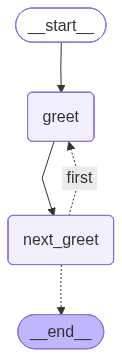

In [17]:

display(Image(app.get_graph().draw_mermaid_png()))

### Example 3

#### Personalized Compliment Agent

{'name': [HumanMessage(content='Alice, you are amazing', additional_kwargs={}, response_metadata={}, id='c70ffbd6-a9b6-4459-8076-b6012929e274'), HumanMessage(content='Bob, you are amazing', additional_kwargs={}, response_metadata={}, id='a2bd53eb-a69d-4ec6-ac9d-3794277b49af')]}


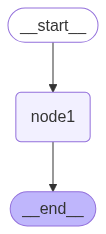

In [18]:
class ComplimentAgent(TypedDict):
    name:Annotated[list[AnyMessage], add_messages]

def compliement(state: ComplimentAgent)->ComplimentAgent:
    text=[HumanMessage(content=f"{name.content}, you are amazing", id=name.id) for name in state['name']]
    return {"name": text}

comp=StateGraph(ComplimentAgent)
comp.add_node("node1", compliement)
comp.set_entry_point("node1")
comp.add_edge("node1",END)
comp_app=comp.compile()

initial = {
    "name": [HumanMessage(content="Alice"), HumanMessage(content="Bob")]
}
result = comp_app.invoke(initial)
print(result)

display(Image(comp_app.get_graph().draw_mermaid_png()))


### Example 4

#### Calculation of Values

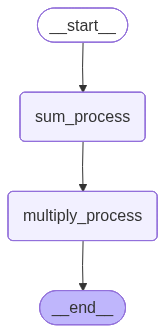

{'values': [1, 2, 3, 4], 'name': 'hrs', 'result': 'Multiply for hrs here is 24', 'add': 10, 'multi': 24}


In [19]:
from functools import reduce


class SumAgent(TypedDict):
    values: list[int]
    name: str
    result: str
    add: int
    multi: int


def sum_values(state: SumAgent) -> SumAgent:
    """This function handles sum of multiple different input"""
    state["result"] = f"Sum for {state['name']} here is {sum(state['values'])}"
    state["add"] = sum(state["values"])
    return state


def multiply_values(state: SumAgent) -> SumAgent:
    """This function handles multiply of multiple different inputs"""
    state["result"] = (
        f"Multiply for {state['name']} here is {reduce(lambda x, y: x*y, (state['values']))}"
    )
    state["multi"] = reduce(lambda x, y: x * y, (state["values"]))
    return state


cal_graph = StateGraph(SumAgent)
cal_graph.add_node("sum_process", sum_values)
cal_graph.add_node("multiply_process", multiply_values)
cal_graph.set_entry_point("sum_process")
cal_graph.add_edge("sum_process", "multiply_process")
cal_graph.set_finish_point("multiply_process")
cal_app = cal_graph.compile()
display(Image(cal_app.get_graph().draw_mermaid_png()))

cal_initial = {"values": [1, 2, 3, 4], "name": "hrs"}
cal_result = cal_app.invoke(cal_initial)
print(cal_result)

### Example 5

#### Conditional Nodes

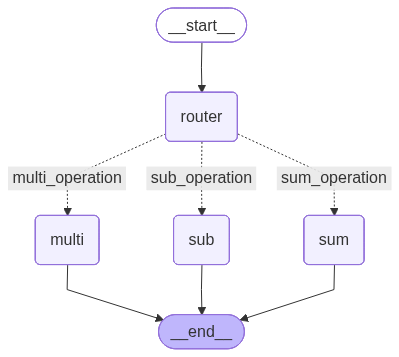

{'num1': 2, 'num2': 4, 'oper': '+', 'result': 6}


In [22]:
class ArithmeticOp(TypedDict):
    num1: int
    num2: int
    oper: str
    result: float


def sumOp(state: ArithmeticOp) -> ArithmeticOp:
    state["result"] = state["num1"] + state["num2"]
    return state


def subOp(state: ArithmeticOp) -> ArithmeticOp:
    state["result"] = state["num1"] - state["num2"]
    return state


def multOp(state: ArithmeticOp) -> ArithmeticOp:
    state["result"] = state["num1"] * state["num2"]
    return state


def decide_next_node(state: ArithmeticOp) -> ArithmeticOp:
    if state["oper"] == "+":
        return "sum_operation"
    elif state["oper"] == "-":
        return "sub_operation"
    else:
        return "multi_operation"


arith_graph = StateGraph(ArithmeticOp)
arith_graph.add_node("sum", sumOp)
arith_graph.add_node("sub", subOp)
arith_graph.add_node("multi", multOp)
arith_graph.add_node("router", lambda state: state)

arith_graph.add_edge(START, "router")
arith_graph.add_conditional_edges(
    "router",
    decide_next_node,
    {"sum_operation": "sum", "sub_operation": "sub", "multi_operation": "multi"},
)
arith_graph.add_edge("sum", END)
arith_graph.add_edge("sub", END)
arith_graph.add_edge("multi", END)

arith_app=arith_graph.compile()
display(Image(arith_app.get_graph().draw_mermaid_png()))
arith_result=arith_app.invoke({"num1":2, "num2":4, "oper":"+"})
print(arith_result)